<a href="https://colab.research.google.com/github/anushkayadav/Denoising_cifar10/blob/master/Denoise_SkipSym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Convolutional Auto-encoders with Symmetric Skip Connections

---

In [4]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import math


In [5]:
# convert data to a normalized torch.FloatTensor
transform = transforms.ToTensor()
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)



num_workers = 0
noise_factor=0.1
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
   plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [23]:
0

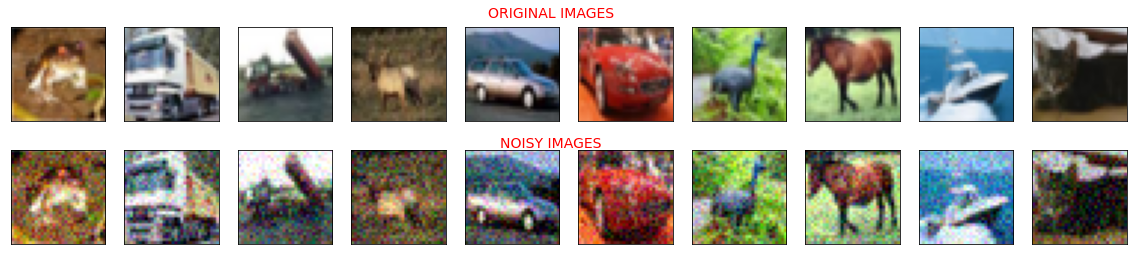

In [24]:
showOrigDec(images,noisy_imgs)

# Denoising

We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

OUR ARCHITECTURE  consists of -
1.   15 Encoding Layers
2.  15 Decoding Layers
3. Symmetric Skip Connections
4. Relu and Batch Normalization after each layer





In [25]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class REDNet30(nn.Module):
    def __init__(self, num_layers=15, num_features=64):
        super(REDNet30, self).__init__()
        self.num_layers = num_layers

        conv_layers = []
        deconv_layers = []

        conv_layers.append(nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True),
                                         nn.BatchNorm2d(num_features)))
        for i in range(num_layers - 1):
            conv_layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                             nn.ReLU(inplace=True),
                                             nn.BatchNorm2d(num_features)))

        for i in range(num_layers - 1):
            deconv_layers.append(nn.Sequential(nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                                               nn.ReLU(inplace=True),
                                               nn.BatchNorm2d(num_features)))
        deconv_layers.append(nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        conv_feats = []
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if (i + 1) % 2 == 0 and len(conv_feats) < math.ceil(self.num_layers / 2) - 1:
                conv_feats.append(x)

        conv_feats_idx = 0
        for i in range(self.num_layers):
            x = self.deconv_layers[i](x)
            if (i + 1 + self.num_layers) % 2 == 0 and conv_feats_idx < len(conv_feats):
                conv_feat = conv_feats[-(conv_feats_idx + 1)]
                conv_feats_idx += 1
                x = x + conv_feat
                x = self.relu(x)

        x += residual
        x = self.relu(x)

        return x

# initialize the NN
model = REDNet30()
model.cuda()
print(model)

REDNet30(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3,

In [26]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
print(type(train_loader))
for data in train_loader:
    images, target = data
    print(target)
    print(images.shape)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])
torch.Size([32, 3, 32, 32])


In [ ]:
# number of epochs to train the model
n_epochs = 40


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs.cuda())
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images.cuda())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

In [29]:
torch.save(model,"denoise_batch.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type REDNet30. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [30]:
torch.load("denoise_batch.pt")

REDNet30(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3,

In [31]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())



# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().cpu()



## **COMPARING IMAGES**

In [44]:


def showOrigNoiseOut(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        imshow(denoise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


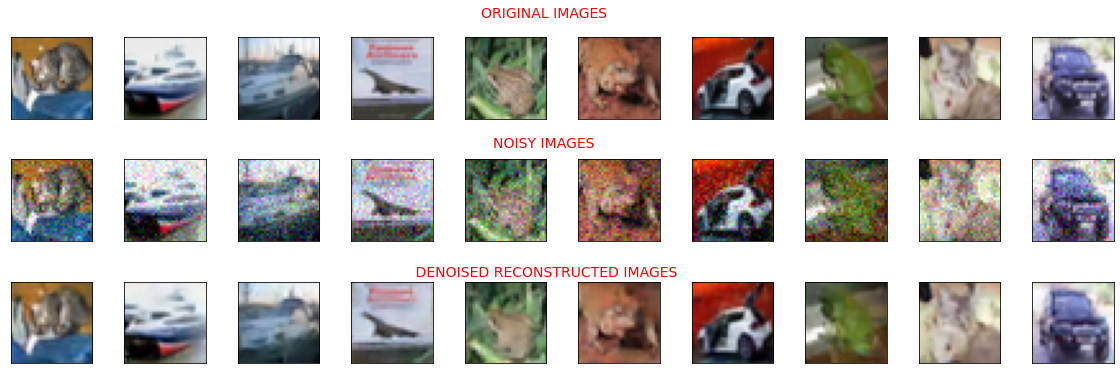

In [45]:
showOrigNoiseOut(images, noisy_imgs, output)

### EVALUATION 

In [46]:
from skimage import metrics

avg_psnr=0
avg_ssim=0
test_size=0
for data in test_loader:
    images= data[0]
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    output = model(noisy_imgs.cuda())
    output = output.view(len(images), 3, 32, 32)
    output = output.detach().cpu()
    batch_avg_psnr=0
    batch_avg_ssim=0
    for i in range(len(images)):
        org=np.transpose(images[i], (1, 2, 0)).numpy()
        denoise=np.transpose(output[i], (1, 2, 0)).numpy()
        batch_avg_psnr+=metrics.peak_signal_noise_ratio(org,denoise)
        batch_avg_ssim+=metrics.structural_similarity(org,denoise,multichannel=True)
    avg_psnr+=batch_avg_psnr
    avg_ssim+=batch_avg_ssim
    test_size+=len(images)

print("On Test data of {} examples:\nAverage PSNR:{:.3f} \nAverage SSIM: {:.3f}".format(test_size,avg_psnr/test_size,avg_ssim/test_size))

On Test data of 10000 examples:
Average PSNR:28.254 
Average SSIM: 0.938
